### Mining GitHub data

We'll be using the GitHub issues for the Readings and Responses of the readings to build a network of classmates upvoting others, as well as using the contents of their text to see how similar are peoples questions.

Let us use [Issue number 6](https://github.com/Computational-Content-Analysis-2020/Readings-Responses-Spring/issues/6). We start with our imports and loading the data. 

In [1]:
import lucem_illud_2020

In [2]:
import requests
from bs4 import BeautifulSoup
from  selenium import webdriver

### Loading page 

We use selenium to open the pages because there is a fair amount of dynamically generated content on the page, such as who upvotes who.

In [3]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
driver = webdriver.Chrome(executable_path="/Users/bhargavvader/open_source/Content-Analysis-2020/chromedriver", chrome_options=options)

In [4]:
url = "https://github.com/Computational-Content-Analysis-2020/Readings-Responses-Spring/issues/6"

In [5]:
driver.get(url)

In [6]:
html = driver.page_source

In [7]:
soup = BeautifulSoup(driver.page_source, 'lxml')

### Data Wrangling

The web page can be a pain to scrape: the key is to search for patterns in where different kinds of information occurs. Since this is a smaller page, we can do some guesswork. Going through the page, I try to see the context of where usernames occur, and add them to a list.

In [8]:
classmate_username = []

In [9]:
for person in soup.find_all('a', {"class": "author link-gray-dark css-truncate-target width-fit"}):
    classmate_username.append(person.text)
    print(person.text)

jamesallenevans
wanitchayap
ihsiehchi
shiyipeng70
iarakshana
nwrim
timqzhang
Sunnyleee
WMhYang
pdiazm
timhannifan
tianyueniu
Harryx113
linghui-wu
Lesopil
DSharm
Yilun0221
lyl010
jsgenan
liu431
bazirou


I now add the text of each of the comment boxes.

In [10]:
classmate_texts = []

In [11]:
for classmate_text in soup.find_all("td"):
    text = []
    for para in classmate_text.find_all("p"):
        text.append(para.text)
    for list_ in classmate_text.find_all("li"):
        text.append(list_.text)
    classmate_texts.append(text)

In [12]:
for text in soup.find_all("textarea", {"name":"issue_comment[body]"}):
    print(text)

In [13]:
len(classmate_username), len(classmate_texts)

(21, 21)

In [14]:
classmate_username[0], classmate_texts[0]

('jamesallenevans',
 ['Post questions about the orienting reading and how to sample content for your projects:',
  'Krippendorff, Klaus. 2004. "Sampling" in Content Analysis: An Introduction to its Methodology. Thousand Oaks, CA: Sage: “Sampling” 111-124.'])

In [15]:
classmate_username[-1], classmate_texts[-1]

('bazirou',
 ['In the reading material, the author mentions informative many times and he/she says some of the text in the content analysis is not informative. My question is how to define the word informative. Is there some specific metric like information entropy to measure how informative the text is?',
  'The mechanism of systematic sample is somewhat similar to random sample so I wonder if systematic sampling is a special case of random sampling.'])

That looks right! Let us create a graph, where each node is a student, and the information assocaited with the node is the text of the speaker.

In [16]:
import networkx as nx

In [17]:
classmate_graph = nx.DiGraph()

In [18]:
for username, text in zip(classmate_username, classmate_texts):
    classmate_graph.add_node(username, text=text)

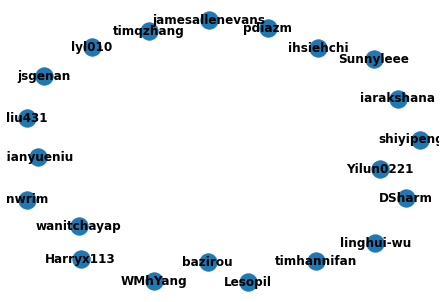

In [19]:
nx.draw(classmate_graph, with_labels=True, font_weight='bold')


We now try and see if we can see who upvoted whom. This information isn't clearly represented in the page: we can get a hint by looking at the generated blurbs in the bottom of the comment with the first few names followed by "and 6 more". So while it is lacking, it does mention who are the first 10, which is still plenty.

Also: not every comment is upvoted. So we must manually check on the page where it stops, and assign the values accordingly. We'll demonstrate that here.

In [20]:
reactions = []

In [21]:
total_reacs = []

In [22]:
for reaction in soup.find_all('div', {"class": "comment-reactions-options"}):
    fans = []
    num = 0
    for button in reaction.find_all("button"):
        info = button["aria-label"]
        if ", and" in info:
            fans_comma, fans_and = info.split(", and ")
            fans_ = fans_comma.split(", ")
            last_fan, _ = fans_and.split(" reacted ")
            if last_fan in classmate_graph.nodes():
                fans_.append(last_fan)
            else:
                num, _ = last_fan.split(" ")
            for fan in fans_:
                fans.append(fan)
            continue
            
        if "reacted with" in info:
            fans_ = []
            fan, _ = info.split(" reacted with")
            if fan in classmate_graph:
                fans_.append(fan)
            else:
                if "and" in fan:
                    fan_1, fan_2 = fan.split(" and ")
                    fans_.append(fan_1)
                    fans_.append(fan_2)
            for fan in fans_:
                fans.append(fan)
                
    total_reacs.append(len(fans) + int(num))
    reactions.append(fans)

In [23]:
total_reacs

[16, 16, 14, 11, 20, 11, 3, 8, 4, 4, 2, 2, 2]

In [24]:
reactions[0]

['ihsiehchi',
 'shiyipeng70',
 'timqzhang',
 'pdiazm',
 'tianyueniu',
 'Harryx113',
 'linghui-wu',
 'Yilun0221',
 'WMhYang',
 'nwrim',
 'ihsiehchi',
 'ihsiehchi']

These are all the reactions. ihsiehchi reacted in multiple ways so they show up more than once. We must also note the shorter size of the reactions list: not everyone has got a reaction. 8 of them, to be precise. Prof. Evans didn't and uptil the 10th comment, all did: after which only linghui-wu and jsgenan got upvotes. Let us be sure to remember this when creating our network!


Let us now create networks to see who upvotes who!

In [25]:
i = 0

In [26]:
for username in classmate_username[1:]:
    classmate_graph.nodes[username]['total_reacs'] = total_reacs[i]
    for fan in reactions[i]:
        if (fan, username) not in classmate_graph.edges():
            classmate_graph.add_edge(fan, username, weight=0)
        if (fan, username) in classmate_graph.edges():
            classmate_graph.edges[(fan, username)]['weight'] += 1
    i += 1
    if i == 11:
        break

In [27]:
rest = ['linghui-wu', 'jsgenan']

In [28]:
for username in rest:
    classmate_graph.nodes[username]['total_reacs'] = total_reacs[i]
    for fan in reactions[i]:
        if (fan, username) not in classmate_graph.edges():
            classmate_graph.add_edge(fan, username, weight=0)
        if (fan, username) in classmate_graph.edges():
            classmate_graph.edges[(fan, username)]['weight'] += 1
    i += 1

Neat: let us now visualise this graph using different NetworkX representations.

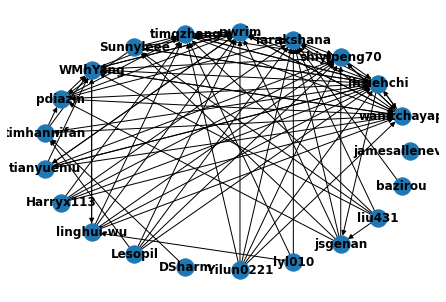

In [29]:
nx.draw_circular(classmate_graph, with_labels=True, font_weight='bold')

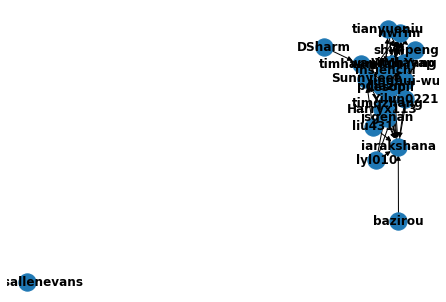

In [30]:
nx.draw_spring(classmate_graph, with_labels=True, font_weight='bold')

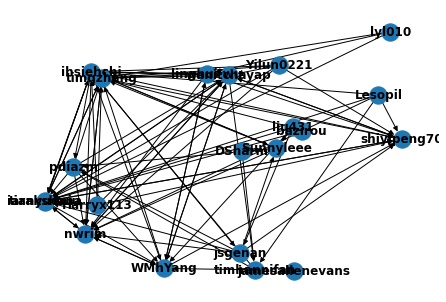

In [31]:
nx.draw_random(classmate_graph, with_labels=True, font_weight='bold')

Hehe - you can see Prof. Evans all alone because he did not vote for anyone or get upvoted. Of course, it is because he wrote the introductory comment. What other patterns can you find? 

In [32]:
from networkx.algorithms.centrality import degree_centrality, in_degree_centrality, out_degree_centrality

In [33]:
degree_centrality(classmate_graph)

{'jamesallenevans': 0.0,
 'wanitchayap': 0.8,
 'ihsiehchi': 0.9500000000000001,
 'shiyipeng70': 0.6000000000000001,
 'iarakshana': 0.65,
 'nwrim': 0.75,
 'timqzhang': 0.8,
 'Sunnyleee': 0.35000000000000003,
 'WMhYang': 0.65,
 'pdiazm': 0.45,
 'timhannifan': 0.4,
 'tianyueniu': 0.35000000000000003,
 'Harryx113': 0.25,
 'linghui-wu': 0.4,
 'Lesopil': 0.25,
 'DSharm': 0.05,
 'Yilun0221': 0.30000000000000004,
 'lyl010': 0.15000000000000002,
 'jsgenan': 0.35000000000000003,
 'liu431': 0.25,
 'bazirou': 0.05}

In [34]:
in_degree_centrality(classmate_graph)

{'jamesallenevans': 0.0,
 'wanitchayap': 0.5,
 'ihsiehchi': 0.5,
 'shiyipeng70': 0.5,
 'iarakshana': 0.55,
 'nwrim': 0.55,
 'timqzhang': 0.55,
 'Sunnyleee': 0.15000000000000002,
 'WMhYang': 0.4,
 'pdiazm': 0.2,
 'timhannifan': 0.2,
 'tianyueniu': 0.1,
 'Harryx113': 0.0,
 'linghui-wu': 0.1,
 'Lesopil': 0.0,
 'DSharm': 0.0,
 'Yilun0221': 0.0,
 'lyl010': 0.0,
 'jsgenan': 0.1,
 'liu431': 0.0,
 'bazirou': 0.0}

In [35]:
out_degree_centrality(classmate_graph)

{'jamesallenevans': 0.0,
 'wanitchayap': 0.30000000000000004,
 'ihsiehchi': 0.45,
 'shiyipeng70': 0.1,
 'iarakshana': 0.1,
 'nwrim': 0.2,
 'timqzhang': 0.25,
 'Sunnyleee': 0.2,
 'WMhYang': 0.25,
 'pdiazm': 0.25,
 'timhannifan': 0.2,
 'tianyueniu': 0.25,
 'Harryx113': 0.25,
 'linghui-wu': 0.30000000000000004,
 'Lesopil': 0.25,
 'DSharm': 0.05,
 'Yilun0221': 0.30000000000000004,
 'lyl010': 0.15000000000000002,
 'jsgenan': 0.25,
 'liu431': 0.25,
 'bazirou': 0.05}

In terms of both responding to others as well as having engaging content: ihsiehchi is up top!

Let us now create a topic model to see what people are commenting about!

In [36]:
import gensim #For topic modeling

unable to import 'smart_open.gcs', disabling that module


In [37]:
all_texts = []

In [38]:
for classmate in classmate_graph.nodes():
    classmate_graph.nodes[classmate]['all_words'] = []
    for sents in classmate_graph.nodes[classmate]['text']:
        for word in lucem_illud_2020.normalizeTokens(sents.lower()):
            classmate_graph.nodes[classmate]['all_words'].append(word)
            
        all_texts.append(lucem_illud_2020.normalizeTokens(sents.lower()))

In [39]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [40]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [41]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)

In [42]:
lda.show_topics()

[(0,
  '0.034*"sample" + 0.021*"question" + 0.014*"content" + 0.013*"analysis" + 0.013*"expert" + 0.011*"method" + 0.011*"issue" + 0.011*"size" + 0.011*"show" + 0.010*"unit"'),
 (1,
  '0.023*"sample" + 0.020*"snowball" + 0.017*"probability" + 0.016*"think" + 0.014*"bias" + 0.014*"method" + 0.014*"datum" + 0.013*"weight" + 0.012*"equally" + 0.012*"informative"'),
 (2,
  '0.106*"sample" + 0.017*"bias" + 0.016*"snowball" + 0.015*"probability" + 0.014*"relevance" + 0.012*"case" + 0.011*"unit" + 0.009*"researcher" + 0.009*"text" + 0.008*"algorithm"'),
 (3,
  '0.028*"content" + 0.025*"analysis" + 0.022*"sample" + 0.020*"validity" + 0.020*"external" + 0.019*"issue" + 0.015*"question" + 0.014*"big" + 0.013*"generalization" + 0.012*"consider"'),
 (4,
  '0.034*"sample" + 0.025*"content" + 0.021*"analysis" + 0.016*"research" + 0.013*"chapter" + 0.012*"question" + 0.011*"weight" + 0.011*"researcher" + 0.010*"informative" + 0.009*"think"')]

So most people are talking about sampling: makes sense. 

In [43]:
for classmate in classmate_graph.nodes():
    classmate_graph.nodes[classmate]['topic_distribution'] = lda.get_document_topics(dictionary.doc2bow(classmate_graph.nodes[classmate]['all_words']), minimum_probability=0)

In [44]:
for classmate in classmate_graph.nodes():
    print(classmate, classmate_graph.nodes[classmate]['topic_distribution'])

jamesallenevans [(0, 0.011476069), (1, 0.011158429), (2, 0.95414364), (3, 0.011691517), (4, 0.01153034)]
wanitchayap [(0, 0.0029374869), (1, 0.0029178897), (2, 0.0030202216), (3, 0.0029461298), (4, 0.98817825)]
ihsiehchi [(0, 0.2688971), (1, 0.6257374), (2, 0.10375998), (3, 0.00080263685), (4, 0.0008028452)]
shiyipeng70 [(0, 0.97627425), (1, 0.0026257522), (2, 0.01580865), (3, 0.0026414061), (4, 0.0026499196)]
iarakshana [(0, 0.0038239649), (1, 0.0038129857), (2, 0.98476857), (3, 0.003794542), (4, 0.0037999381)]
nwrim [(0, 0.74197257), (1, 0.002758088), (2, 0.24971303), (3, 0.002777425), (4, 0.002778838)]
timqzhang [(0, 0.0012154912), (1, 0.0012251814), (2, 0.4860846), (3, 0.49139002), (4, 0.020084707)]
Sunnyleee [(0, 0.008806439), (1, 0.048040994), (2, 0.008859006), (3, 0.56788385), (4, 0.36640966)]
WMhYang [(0, 0.06797946), (1, 0.0025193605), (2, 0.92445046), (3, 0.0025245638), (4, 0.0025261443)]
pdiazm [(0, 0.41562983), (1, 0.11840279), (2, 0.26423463), (3, 0.18490863), (4, 0.016824

How similar are these to each other?

In [45]:
from gensim.matutils import kullback_leibler
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns

In [46]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [47]:
L = []
for classmate_1 in classmate_graph.nodes():
    p = classmate_graph.nodes[classmate_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for classmate_2 in classmate_graph.nodes():
        q = classmate_graph.nodes[classmate_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

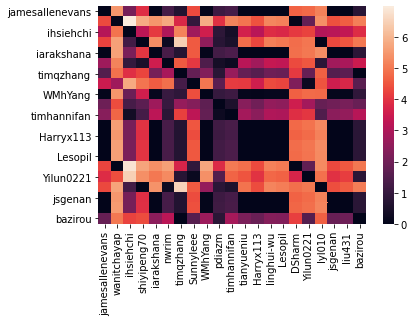

In [48]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(classmate_graph.nodes()), index = list(classmate_graph.nodes()))
ax = sns.heatmap(div)
plt.show()

We can more closely inspect this plot to see how similar are each pair of comments. :)